# Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix, recall_score, precision_score, f1_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample
import random
import os
import pickle
from sklearn.model_selection import train_test_split, GridSearchCV
import numpy as np

# Functions to Compare the Models

- Para a etapa de processamento foi aplicado tanto MinMax quanto StandardScale, sendo essa com mais cara de MinMax para as variável numéricas, já que suas distribuições apresentavam caráter uniforme;
- A etapa de pré-processamento de MinMax não afeta a performance em modelagens com árvores, mas essa foi mantida pela regressão logística. 

In [2]:
def models_evaluation(X_train, X_test, y_train, y_test, balance_bagging=True, weights=True):
    
    if weights == True:
        sample_weights = np.zeros(len(y_train))
        sample_weights[y_train == 0] = 1.0
        sample_weights[y_train == 1] = len(y_train[y_train == 0])/len(y_train[y_train == 1])
    else:
        sample_weights = None
    
    model_pipeline_rfc_mm = Pipeline([('scaler', MinMaxScaler()), ('classifier', RandomForestClassifier())])
    model_pipeline_dtc_mm = Pipeline([('scaler', MinMaxScaler()), ('classifier', DecisionTreeClassifier())])
    model_pipeline_rfc_std = Pipeline([('scaler', StandardScaler()), ('classifier', RandomForestClassifier())])
    model_pipeline_dtc_std = Pipeline([('scaler', StandardScaler()), ('classifier', DecisionTreeClassifier())])
    model_pipeline_lg_mm = Pipeline([('scaler', MinMaxScaler()), ('classifier', LogisticRegression())])
    model_pipeline_lg_std = Pipeline([('scaler', StandardScaler()), ('classifier', LogisticRegression())])
    model_pipeline_gd_mm = Pipeline([('scaler', MinMaxScaler()), ('classifier', GradientBoostingClassifier())])
    model_pipeline_gd_std = Pipeline([('scaler', StandardScaler()), ('classifier', GradientBoostingClassifier())])
    
    model_rfc_mm = model_pipeline_rfc_mm.fit(X_train, y_train, classifier__sample_weight = sample_weights)
    model_dtc_mm = model_pipeline_dtc_mm.fit(X_train, y_train, classifier__sample_weight = sample_weights)
    model_rfc_std = model_pipeline_rfc_std.fit(X_train, y_train, classifier__sample_weight = sample_weights)
    model_dtc_std = model_pipeline_dtc_std.fit(X_train, y_train, classifier__sample_weight = sample_weights)
    model_lg_mm = model_pipeline_lg_mm.fit(X_train, y_train, classifier__sample_weight = sample_weights)
    model_lg_std = model_pipeline_lg_std.fit(X_train, y_train, classifier__sample_weight = sample_weights)
    model_gd_mm = model_pipeline_gd_mm.fit(X_train, y_train, classifier__sample_weight = sample_weights)
    model_gd_std = model_pipeline_gd_std.fit(X_train, y_train, classifier__sample_weight = sample_weights)
    
    
    y_pred_rfc_mm = model_rfc_mm.predict(X_test)
    y_pred_dtc_mm = model_dtc_mm.predict(X_test)
    y_pred_rfc_std = model_rfc_std.predict(X_test)
    y_pred_dtc_std = model_dtc_std.predict(X_test)
    y_pred_lg_mm = model_lg_mm.predict(X_test)
    y_pred_lg_std = model_lg_std.predict(X_test)
    y_pred_gd_mm = model_gd_mm.predict(X_test)
    y_pred_gd_std = model_gd_std.predict(X_test)
    
    
    f1_rfc_mm = f1_score(y_test, y_pred_rfc_mm)
    f1_rfc_std = f1_score(y_test, y_pred_rfc_std)
    f1_dtc_mm = f1_score(y_test, y_pred_dtc_mm)
    f1_dtc_std = f1_score(y_test, y_pred_dtc_std)
    f1_lg_mm = f1_score(y_test, y_pred_lg_mm)
    f1_lg_std = f1_score(y_test, y_pred_lg_std)
    f1_gd_mm = f1_score(y_test, y_pred_gd_mm)
    f1_gd_std = f1_score(y_test, y_pred_gd_std)
    
    if balance_bagging == False:
        return {'rfc_mm':f1_rfc_mm, 'dtc_mm':f1_dtc_mm, 'lg_mm':f1_lg_mm, 'gd_mm':f1_gd_mm,
                'rfc_std':f1_rfc_std, 'dtc_std':f1_dtc_std, 'lg_std':f1_lg_std, 'gd_std':f1_gd_std}
    else:
        model_pipeline_bb_gd_mm = Pipeline([('scaler', MinMaxScaler()),
                                         ('classifier', BalancedBaggingClassifier(
                                             base_estimator=GradientBoostingClassifier(),
                                             sampling_strategy='not majority',
                                             replacement=False,
                                             random_state=42))])

        model_pipeline_bb_gd_std = Pipeline([('scaler', StandardScaler()),
                                         ('classifier', BalancedBaggingClassifier(
                                             base_estimator=GradientBoostingClassifier(),
                                             sampling_strategy='not majority',
                                             replacement=False,
                                             random_state=42))])

        model_bb_gd_mm = model_pipeline_bb_gd_mm.fit(X_train, y_train)
        model_bb_gd_std = model_pipeline_bb_gd_std.fit(X_train, y_train)

        y_pred_bb_gd_mm = model_bb_gd_mm.predict(X_test)
        y_pred_bb_gd_std = model_bb_gd_std.predict(X_test)

        f1_bb_gd_mm = f1_score(y_test, y_pred_bb_gd_mm)
        f1_bb_gd_std = f1_score(y_test, y_pred_bb_gd_std)
        return {'rfc_mm':f1_rfc_mm, 'dtc_mm':f1_dtc_mm, 'lg_mm':f1_lg_mm, 'gd_mm':f1_gd_mm, 'bb_gd_mm':f1_bb_gd_mm,
                'rfc_std':f1_rfc_std, 'dtc_std':f1_dtc_std, 'lg_std':f1_lg_std, 'gd_std':f1_gd_std, 'bb_gd_std':f1_bb_gd_std}

In [3]:
def change_threshold(X, threshold):
    return X.apply(lambda x: 1 if x>=threshold else 0)

In [4]:
def precision_recall_table(y_train, y_pred_prob, step = 0.01):
    cutoffs = np.arange(step,1,step)
    
    precision = []
    recall = []
    accuracy = []
    f1 = []
    step = []
    for i in cutoffs:
        
        y_pred_threshold = change_threshold(y_pred_prob, i)
        
        precision.append(precision_score(y_train, y_pred_threshold))
        recall.append(recall_score(y_train, y_pred_threshold))
        accuracy.append(accuracy_score(y_train, y_pred_threshold))
        f1.append(f1_score(y_train, y_pred_threshold))
        
        step.append(i)
    return {'step': step, 'precision': precision, 'recall': recall, 'accuracy': accuracy, 'f1':f1}

# Importing Database

In [5]:
df = pd.read_csv("https://raw.githubusercontent.com/VD-git/cs-stone-fraud/main/source/dados.csv?token=GHSAT0AAAAAABRQJA2MOQECD4RL3FLMAARGYQH6JRA")
df.loc[:, "id_subestacao"] = df.loc[:, "id_subestacao"].astype('object')

# Transforming into a numerical DB

In [6]:
categorical_columns = [i for i,j in zip(df.columns, df.dtypes) if j == 'object']
numerical_columns = [i for i,j in zip(df.columns, df.dtypes) if j == 'int64']

In [7]:
df_dummies = pd.get_dummies(df[categorical_columns[1:]],prefix=categorical_columns[1:], columns = categorical_columns[1:], drop_first = False)
df_final = pd.concat([df_dummies, df[numerical_columns]], axis = 1).drop('classe_cliente_normal', axis = 1)

In [8]:
X = df_final.drop(["classe_cliente_fraudador"], axis = 1)
y = df_final['classe_cliente_fraudador']

# Pela base ser desbalanceada, foram avaliadas algumas medidas para ver qual retornava o melhor resultado para realizar o posterior tuning do modelo

- Avaliação sem nenhum tratamente para ter um benchmark;
- Aplicação de sample_weights para dar pesos diferentes para fraudadores e pesar mais esses dados. A aplicação dos pesos foi feita por meio da relação com que os dados estavam desbalanceados, como é colocado na função 'models_evaluation()';
- Uso de Oversampling com SMOTE e resample;
- Uso de Undersampling tirando um sample de mesmo tamanho da base de não fraudadores.

# Teste 1: Sem Tuning dos parâmetros e manuseio da DB (Benchmark)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42, stratify = y)

In [10]:
models_evaluation(X_train, X_test, y_train, y_test, balance_bagging=False, weights=False)

{'rfc_mm': 0.3996889580093313,
 'dtc_mm': 0.3129810159055926,
 'lg_mm': 0.07462686567164178,
 'gd_mm': 0.4295652173913043,
 'rfc_std': 0.40062111801242234,
 'dtc_std': 0.3090439276485788,
 'lg_std': 0.07462686567164178,
 'gd_std': 0.4295652173913043}

# Teste 2: Sem Tuning dos parâmetros e com manuseio da DB

- Aplicando Weight

In [11]:
models_evaluation(X_train, X_test, y_train, y_test, balance_bagging=False, weights=True)

{'rfc_mm': 0.4,
 'dtc_mm': 0.3017429193899782,
 'lg_mm': 0.16429072213133908,
 'gd_mm': 0.1909427966101695,
 'rfc_std': 0.39874902267396406,
 'dtc_std': 0.3002183406113537,
 'lg_std': 0.16425233644859816,
 'gd_std': 0.1909427966101695}

- Oversampling (SMOTE)

In [12]:
X_resampled, Y_resampled = SMOTE(random_state = 42).fit_resample(X_train, y_train)

In [13]:
models_evaluation(X_resampled, X_test, Y_resampled, y_test, balance_bagging=False, weights=False)

{'rfc_mm': 0.37218543046357616,
 'dtc_mm': 0.3049974240082432,
 'lg_mm': 0.2533936651583711,
 'gd_mm': 0.3845036319612591,
 'rfc_std': 0.3712574850299402,
 'dtc_std': 0.30368098159509205,
 'lg_std': 0.25316455696202533,
 'gd_std': 0.3845036319612591}

- Oversampling (resample)

In [14]:
Xy_train = pd.concat([X_train, y_train], axis = 1)
Xy_train_fraud = Xy_train[Xy_train['classe_cliente_fraudador'] == 1]
Xy_train_non_fraud = Xy_train[Xy_train['classe_cliente_fraudador'] == 0]
Xy_train_fraud_upsample = resample(Xy_train_fraud, replace=True, n_samples= len(Xy_train_non_fraud), random_state = 42)

In [15]:
Xy_train_oversampling = pd.concat([Xy_train_fraud_upsample,Xy_train_non_fraud], axis=0, ignore_index=True).sample(len(Xy_train_fraud_upsample)*2)

In [16]:
X_train_oversampling = Xy_train_oversampling.drop("classe_cliente_fraudador", axis = 1)
y_train_oversampling = Xy_train_oversampling["classe_cliente_fraudador"]

In [17]:
models_evaluation(X_train_oversampling, X_test, y_train_oversampling, y_test, balance_bagging=False, weights=False)

{'rfc_mm': 0.35485975212002613,
 'dtc_mm': 0.3084468664850136,
 'lg_mm': 0.16426816426816426,
 'gd_mm': 0.1908790482485129,
 'rfc_std': 0.35456336178594877,
 'dtc_std': 0.31417624521072796,
 'lg_std': 0.16426816426816426,
 'gd_std': 0.1908790482485129}

- Undersampling

In [18]:
Xy_train = pd.concat([X_train, y_train], axis = 1)
Xy_train_fraud = Xy_train[Xy_train['classe_cliente_fraudador'] == 1]
Xy_train_non_fraud = Xy_train[Xy_train['classe_cliente_fraudador'] == 0].sample(len(Xy_train[Xy_train['classe_cliente_fraudador'] == 1]))
Xy_train_undersamplig = pd.concat([Xy_train_fraud,Xy_train_non_fraud], axis=0, ignore_index=True).sample(len(Xy_train_fraud)*2)

In [19]:
X_train_undersamplig = Xy_train_undersamplig.drop("classe_cliente_fraudador", axis = 1)
y_train_undersamplig = Xy_train_undersamplig["classe_cliente_fraudador"]

In [20]:
models_evaluation(X_train_undersamplig, X_test, y_train_undersamplig, y_test, balance_bagging=False, weights=False)

{'rfc_mm': 0.1627715795654727,
 'dtc_mm': 0.13209302325581396,
 'lg_mm': 0.16383781235266384,
 'gd_mm': 0.18876816337216915,
 'rfc_std': 0.1641013497513616,
 'dtc_std': 0.13125512715340443,
 'lg_std': 0.1633133309801153,
 'gd_std': 0.18879287771667974}

Feitas as avaliações, viu que a nenhuma das aplicações técnicas foram promissoras no caso de árvores, já no caso de logistic regression, foi a de Oversampling com SMOTE. No entanto, o melhor resultado foi obtido para uma árvore com boosting, sendo essa a mantida.

# Tuning

Pelo fato de ser uma árvore e o pré-processamento por StandardScale fornecer o mesmo f1_score que por MinMax, não faz sentido manter essa etapa, ela só irá gastar memória, visto como é o funcionamento de segregação em árvores.

In [21]:
GBC_raw = GradientBoostingClassifier().fit(X_train, y_train)

In [22]:
y_pred = GBC_raw.predict(X_test)

In [23]:
f1_score(y_test, y_pred)

0.4295652173913043

- Para a etapa de tuning dos hiperparâmetros foi usado o GridSearchCV com foco na métrica de f1 para pesar tanto a precisão quanto a recall. Tento em mente que a acurácia pode ser uma métrica alvo falha para se ter devido à desproporção dos dados.

In [24]:
parameters = {
    'n_estimators': np.linspace(100, 300, num = 3, dtype='int16'),
    'max_depth': np.linspace(4, 6, num = 3, dtype='int16'),
    'max_features': ['auto'],
    'min_samples_leaf': np.linspace(100, 300, num = 3, dtype='int16')
}

In [25]:
grid_search_model = GridSearchCV(estimator=GradientBoostingClassifier(), param_grid=parameters,
                                 cv=3, verbose=1, n_jobs=-1, scoring='f1')

In [26]:
grid_search_model.fit(X_train, y_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  9.6min
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed: 20.4min finished


GridSearchCV(cv=3, estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'max_depth': array([4, 5, 6], dtype=int16),
                         'max_features': ['auto'],
                         'min_samples_leaf': array([100, 200, 300], dtype=int16),
                         'n_estimators': array([100, 200, 300], dtype=int16)},
             scoring='f1', verbose=1)

In [27]:
grid_search_model.best_params_

{'max_depth': 5,
 'max_features': 'auto',
 'min_samples_leaf': 200,
 'n_estimators': 300}

Com o n_estimator ficou travado no limite na grid fornecida anteriormente, será feita uma nova avaliação com ele apenas

In [28]:
grid_search_model = GridSearchCV(estimator=GradientBoostingClassifier(max_depth = 5,
                                                                      max_features = 'auto',
                                                                      min_samples_leaf = 200),
                                 param_grid={'n_estimators': np.linspace(300, 1000, num = 8, dtype='int16')},
                                 cv=3, verbose=1, n_jobs=-1, scoring='f1')

In [29]:
grid_search_model.fit(X_train, y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed: 21.6min finished


GridSearchCV(cv=3,
             estimator=GradientBoostingClassifier(max_depth=5,
                                                  max_features='auto',
                                                  min_samples_leaf=200),
             n_jobs=-1,
             param_grid={'n_estimators': array([ 300,  400,  500,  600,  700,  800,  900, 1000], dtype=int16)},
             scoring='f1', verbose=1)

In [30]:
grid_search_model.best_params_

{'n_estimators': 300}

- Realizado o GridSearchCV é possível realizar o treino do modelo com os melhores parâmetros.

In [31]:
GBC = GradientBoostingClassifier(max_depth = 5, max_features = 'auto', min_samples_leaf = 200, n_estimators = 300)

In [32]:
GBC.fit(X_train, y_train)

GradientBoostingClassifier(max_depth=5, max_features='auto',
                           min_samples_leaf=200, n_estimators=300)

In [33]:
y_pred = GBC.predict(X_test)

In [34]:
f1_score(y_test, y_pred)

0.4295652173913043

In [35]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     29097
           1       1.00      0.27      0.43       903

    accuracy                           0.98     30000
   macro avg       0.99      0.64      0.71     30000
weighted avg       0.98      0.98      0.97     30000



- Mesmo com o tuning dos hiperparâmetros, foi visto que não houve uma melhor significativa do valor de f1 score, além de apresentar um recall relativamente baixo, deixando passar muitos fraudadores, para isso o que será feito agora é uma reavaliação do threshold de classificação, até então o padrão de 50 %.

In [36]:
y_pred_prob = pd.DataFrame(GBC.predict_proba(X_train)).iloc[:,1]

In [37]:
y_train_prob = pd.DataFrame(GBC.predict_proba(X_train)).iloc[:,1]
y_train_real = pd.DataFrame(y_train.values)[0]
y_train_prob_real = pd.concat([y_train_prob, y_train_real], axis = 1).rename(columns={0: "real", 1: "predicted"})

In [38]:
report_fraud = pd.DataFrame(precision_recall_table(y_train_prob_real['real'], y_train_prob_real['predicted']))

In [39]:
report_fraud.head()

,step,precision,recall,accuracy,f1
0,0.01,0.064044,0.973990,0.570533,0.120186
1,0.02,0.089239,0.926121,0.713117,0.162792
2,0.03,0.116105,0.869120,0.796792,0.204846
3,0.04,0.139775,0.808522,0.844375,0.238346
4,0.05,0.165866,0.764250,0.877150,0.272575


In [40]:
threshold = report_fraud[report_fraud['f1'] == report_fraud['f1'].max()]['step'].values[0]
report_fraud[report_fraud['step'] == threshold]

,step,precision,recall,accuracy,f1
18,0.19,0.728956,0.359436,0.976683,0.481468


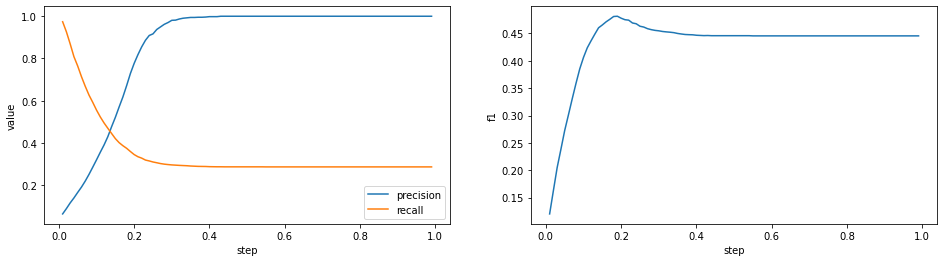

In [41]:
fig, axs = plt.subplots(1,2)
fig.set_figwidth(16)
sns.lineplot(y = report_fraud['precision'], x = report_fraud['step'], ax=axs[0], legend=True)
sns.lineplot(y = report_fraud['recall'], x = report_fraud['step'], ax=axs[0], legend=True)
axs[0].legend(['precision', 'recall'])
axs[0].set_ylabel('value')
sns.lineplot(y = report_fraud['f1'], x = report_fraud['step'], ax=axs[1])

In [42]:
print(classification_report(y_train, change_threshold(y_pred_prob, 0.50)))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    116386
           1       1.00      0.29      0.45      3614

    accuracy                           0.98    120000
   macro avg       0.99      0.64      0.72    120000
weighted avg       0.98      0.98      0.97    120000



In [43]:
print(classification_report(y_train, change_threshold(y_pred_prob, threshold)))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    116386
           1       0.73      0.36      0.48      3614

    accuracy                           0.98    120000
   macro avg       0.85      0.68      0.73    120000
weighted avg       0.97      0.98      0.97    120000



- Fazendo a alteração de threshold é possível visualizar uma melhora na performance de f1 score, equilibrando precision e recall;
- Algo que pode ser revisto pela equipe de negócios, se for interessante para eles, é a mudança de threshold a fim de ter um maior recall de fraudadores. Sempre tendo em mente que baixar o threshold aumenta o recall, mas diminui a precisão (na qual eu declaro fraudadores, clients que não são fraudadores).

# Saving the model

In [44]:
os.chdir('C:\\Users\\VICTOR\\Desktop')
filename = 'fraud_model.sav'
pickle.dump(GBC, open(filename, 'wb'))